In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import datanewn as dt
import model_FCN_U as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
from pytorch_msssim import msssim
# fcn+U

In [2]:
# print gpu
torch.cuda.set_device(0)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 0
8
(7, 0)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"
print(device)

cuda:0


In [ ]:
# generate csv file, run only for the first time
import csvgenerator as csvg
# csvg.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
print(csvFilePath)
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

/deepdata/adib/HEtoSHG/cs766/Data/image_files.csv


In [5]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=100,
                        shuffle=True, num_workers=0)
print(len(transformed_dataset))

1004324


In [ ]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [ ]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'encoderresinfo.pth')
model = md.Net()
model.load_state_dict(torch.load(path))
model.eval()

In [6]:
criterionL = nn.L1Loss()
criterionL = criterionL.cuda()

In [7]:
model = md.Net().to(device)

In [8]:
def trainMS(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
#         lossMSE = criterionMSE(output, targetf)  
        lossMSE = criterionL(output, targetf)
        lossSSIM = 1-msssim(output, targetf, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossL1: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

In [17]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            
            input = input[0:32, :, :, :]
            input_batch = input_batch[0:32, :, :, :]
            label_batch = label_batch[0:32, :, :]
            
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           
            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()
    
            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionL(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

In [13]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'fcnU_0412_1.pth')
torch.save(model.state_dict(), path)

In [10]:
l = 0.01
p = 0.75
windowsize = 8
for epoch in range(1, 200 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*1
        l = l*1
        if windowsize >= 8:
            windowsze = 8
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    trainMS(epoch, p, windowsize)

lossL1: 0.4009872078895569 lossSSIM: 0.8474476337432861
===> Epoch[1](0/10044): Loss: 0.5126
lossL1: 0.3842587172985077 lossSSIM: 0.7367924451828003
===> Epoch[1](50/10044): Loss: 0.4724
lossL1: 0.37689897418022156 lossSSIM: 0.7352110147476196
===> Epoch[1](100/10044): Loss: 0.4665
lossL1: 0.3531245291233063 lossSSIM: 0.7734578251838684
===> Epoch[1](150/10044): Loss: 0.4582
lossL1: 0.34393155574798584 lossSSIM: 0.7632216811180115
===> Epoch[1](200/10044): Loss: 0.4488
lossL1: 0.33973896503448486 lossSSIM: 0.7440087795257568
===> Epoch[1](250/10044): Loss: 0.4408
lossL1: 0.3242618441581726 lossSSIM: 0.7420476675033569
===> Epoch[1](300/10044): Loss: 0.4287
lossL1: 0.30667629837989807 lossSSIM: 0.74066561460495
===> Epoch[1](350/10044): Loss: 0.4152
lossL1: 0.31560826301574707 lossSSIM: 0.7258949279785156
===> Epoch[1](400/10044): Loss: 0.4182
lossL1: 0.3024117648601532 lossSSIM: 0.7170566320419312
===> Epoch[1](450/10044): Loss: 0.4061
lossL1: 0.294432133436203 lossSSIM: 0.692238330841

KeyboardInterrupt: 

In [12]:
l = 0.001
p = 0.5
windowsize = 8
for epoch in range(1, 200 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*1
        l = l*1
        if windowsize >= 8:
            windowsze = 8
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    trainMS(epoch, p, windowsize)

lossL1: 0.05464537814259529 lossSSIM: 0.5280883312225342
===> Epoch[1](0/10044): Loss: 0.2914
lossL1: 0.05490116402506828 lossSSIM: 0.5291681289672852
===> Epoch[1](50/10044): Loss: 0.2920
lossL1: 0.055428627878427505 lossSSIM: 0.5405387282371521
===> Epoch[1](100/10044): Loss: 0.2980
lossL1: 0.05693845823407173 lossSSIM: 0.533942699432373
===> Epoch[1](150/10044): Loss: 0.2954
lossL1: 0.06266807019710541 lossSSIM: 0.5518646240234375
===> Epoch[1](200/10044): Loss: 0.3073
lossL1: 0.057100724428892136 lossSSIM: 0.5234122276306152
===> Epoch[1](250/10044): Loss: 0.2903
lossL1: 0.05913175269961357 lossSSIM: 0.5314880609512329
===> Epoch[1](300/10044): Loss: 0.2953
lossL1: 0.06082750856876373 lossSSIM: 0.566806972026825
===> Epoch[1](350/10044): Loss: 0.3138
lossL1: 0.059480857104063034 lossSSIM: 0.5713151693344116
===> Epoch[1](400/10044): Loss: 0.3154
lossL1: 0.06406564265489578 lossSSIM: 0.582257866859436
===> Epoch[1](450/10044): Loss: 0.3232
lossL1: 0.060235895216464996 lossSSIM: 0.56

lossL1: 0.055261142551898956 lossSSIM: 0.5363656282424927
===> Epoch[1](4250/10044): Loss: 0.2958
lossL1: 0.05135880783200264 lossSSIM: 0.4778493046760559
===> Epoch[1](4300/10044): Loss: 0.2646
lossL1: 0.06461221724748611 lossSSIM: 0.562964677810669
===> Epoch[1](4350/10044): Loss: 0.3138
lossL1: 0.0486430823802948 lossSSIM: 0.4774717092514038
===> Epoch[1](4400/10044): Loss: 0.2631
lossL1: 0.05426982045173645 lossSSIM: 0.5262185335159302
===> Epoch[1](4450/10044): Loss: 0.2902
lossL1: 0.05676644295454025 lossSSIM: 0.5759660005569458
===> Epoch[1](4500/10044): Loss: 0.3164
lossL1: 0.06457741558551788 lossSSIM: 0.5902881026268005
===> Epoch[1](4550/10044): Loss: 0.3274
lossL1: 0.0690128356218338 lossSSIM: 0.5849548578262329
===> Epoch[1](4600/10044): Loss: 0.3270
lossL1: 0.052260179072618484 lossSSIM: 0.4844856262207031
===> Epoch[1](4650/10044): Loss: 0.2684
lossL1: 0.06204671040177345 lossSSIM: 0.5776431560516357
===> Epoch[1](4700/10044): Loss: 0.3198
lossL1: 0.06468766182661057 los

KeyboardInterrupt: 

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


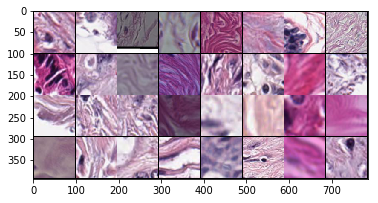

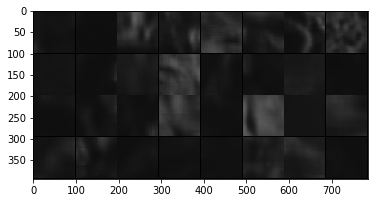

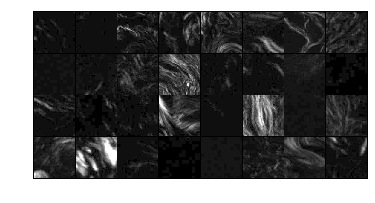

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


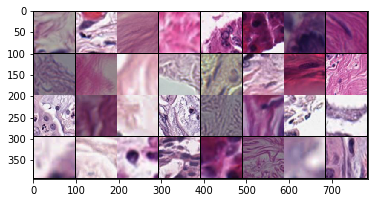

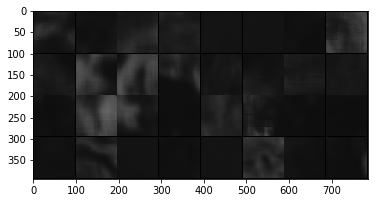

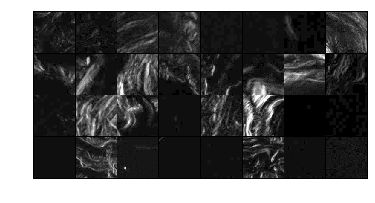

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


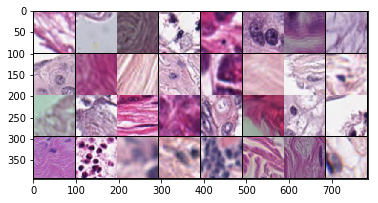

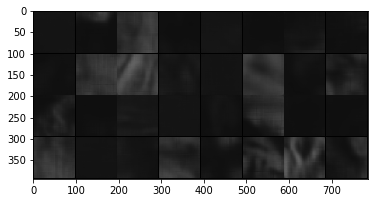

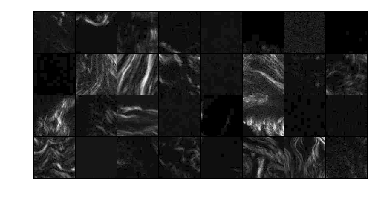

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


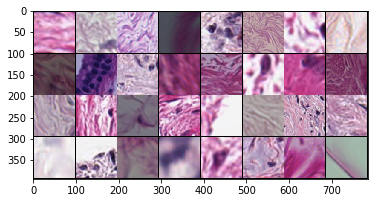

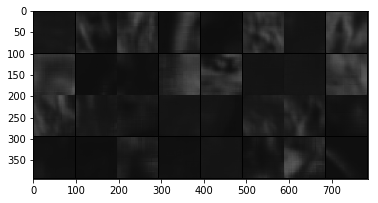

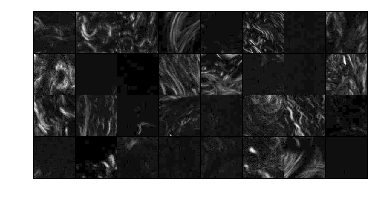

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


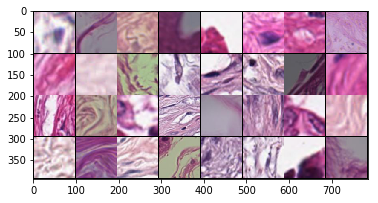

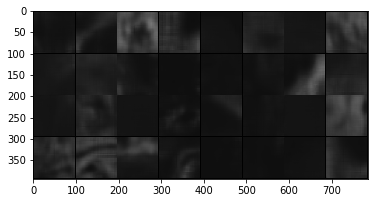

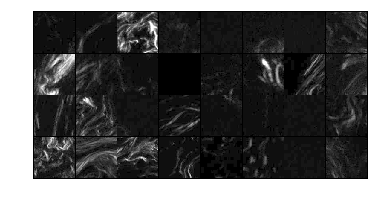

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


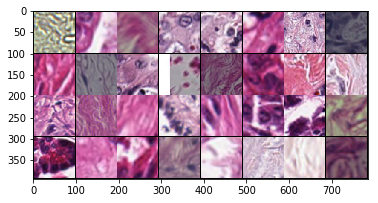

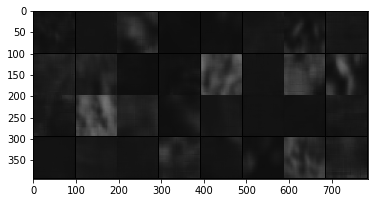

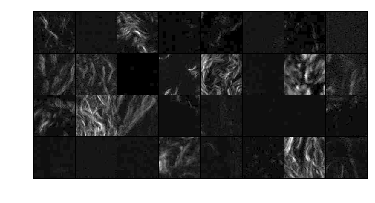

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


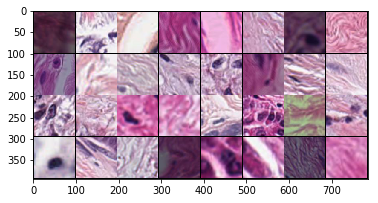

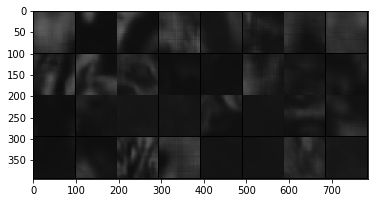

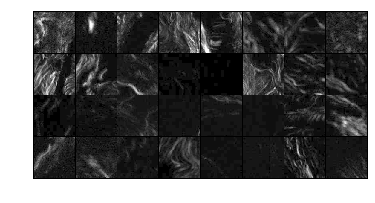

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


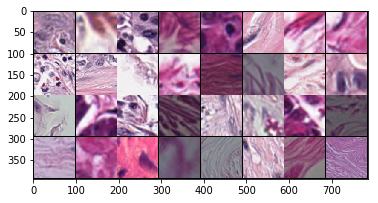

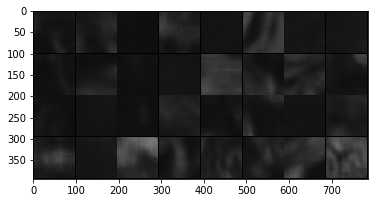

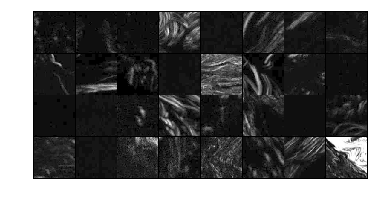

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


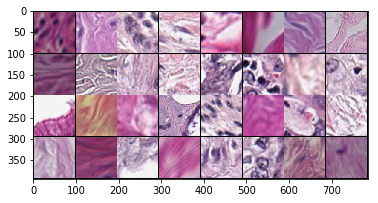

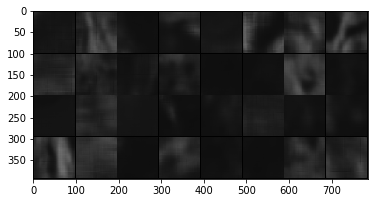

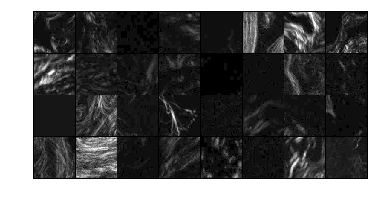

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


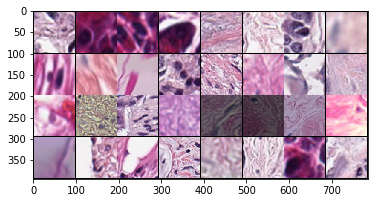

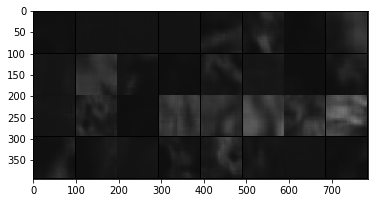

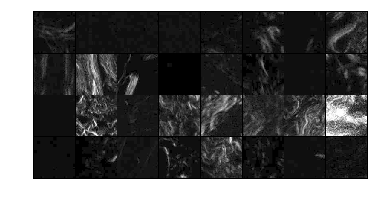

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


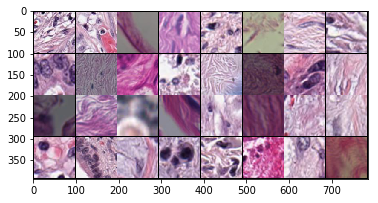

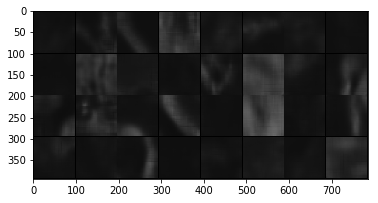

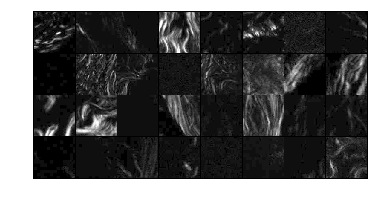

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


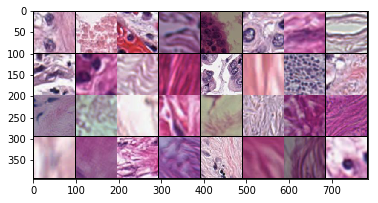

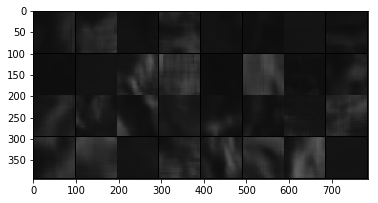

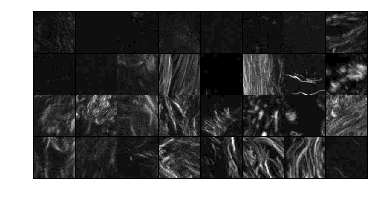

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


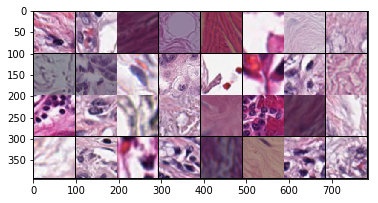

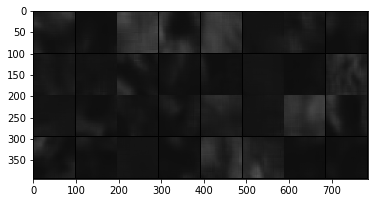

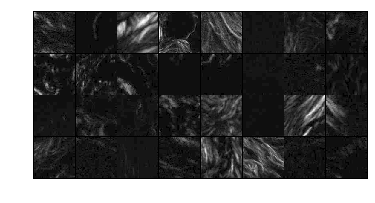

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


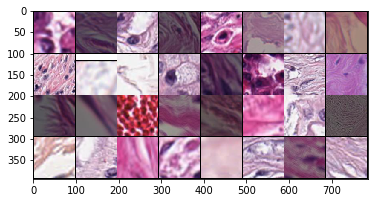

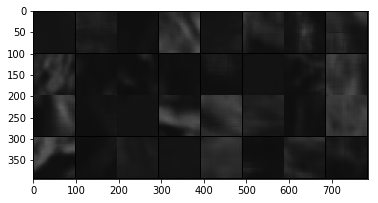

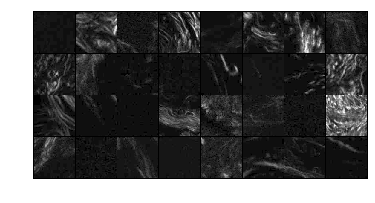

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


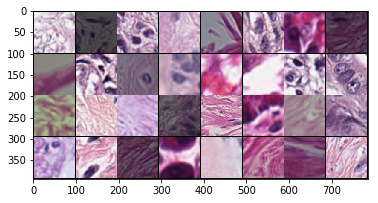

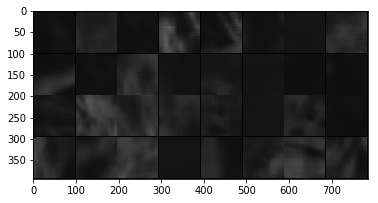

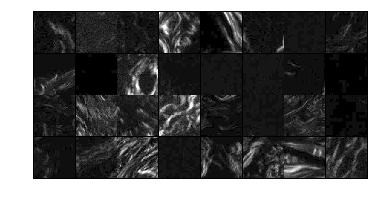

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


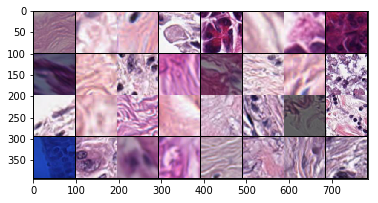

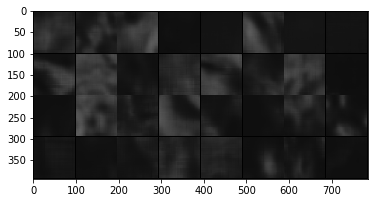

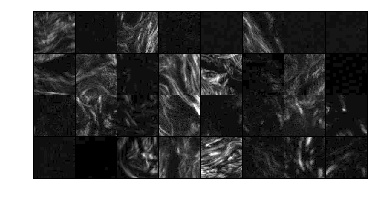

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


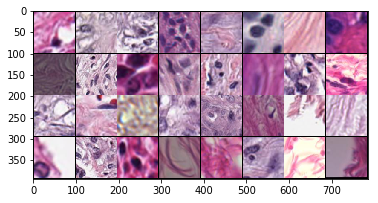

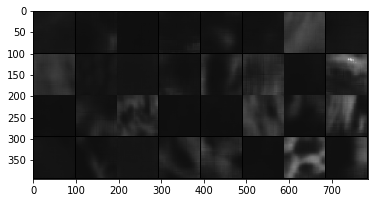

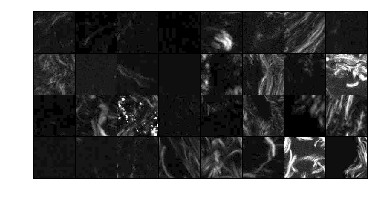

===> Avg. PSNR: nan dB


In [18]:
test()